# QOSF Screening Task 2 
## Problem Statement :
Prepare 4 random 4-qubit quantum states of your choice.
Create and train a variational circuit that transforms input states into predefined output states. Namely,

 $\circ$ if random state 1 is provided, it returns state $|0011\rangle$
 
 $\circ$ if random state 2 is provided, it returns state $|0101\rangle$
 
 $\circ$ if random state 3 is provided, it returns state $|1010\rangle$
 
 $\circ$ if random state 4 is provided, it returns state $|1100\rangle$

What would happen if you provided a different state?

Analyze and discuss the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import SLSQP
import warnings
warnings.filterwarnings('ignore')
import quarkseid

`quarkseid.py` is a python file which contains the code to some of the functions used below.

The SLSQP optimizer is used with maximum iterations set to be 1000. <br>
`statevector_simulator` is chosen as the simulator.

In [2]:
opt = SLSQP(maxiter = 1000)
simltr = QuantumInstance(Aer.get_backend("statevector_simulator"))

## Bars and Stripes Representation:
2x2 Bars and stripes representation is given below by calling function get_bars_and_stripes in python file `quarkseid.py` .

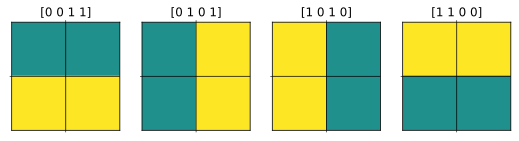

In [3]:
target_states = [str(e).replace(' ','').replace('[','').replace(']','') for e in quarkseid.get_bars_and_stripes(2,2)]
del target_states[-1]
del target_states[0]
random_states = quarkseid.generate_random_states()
%matplotlib inline
import matplotlib.pyplot as plt
data = quarkseid.get_bars_and_stripes(2,2)
data = np.delete(data,5,0)
data = np.delete(data,0,0)
n_points, n_qubits  =  data.shape

n,m=2,2
fig, ax_b = plt.subplots(1, data.shape[0], figsize=(9,2))   #visualization of bars and stripes data set

for i in range(data.shape[0]):
    ax_b[i].matshow(data[i].reshape(n, m), vmin=-1, vmax=1)
    
    ax_b[i].set_xticks([])
    ax_b[i].set_yticks([])
    
    ax_b[i].set_xticks([0.5], minor=True);
    ax_b[i].set_yticks([0.5], minor=True);
    
    ax_b[i].set_title(data[i])
    ax_b[i].grid(which='minor', color='black', linestyle='-', linewidth=0.75)
    
'''sample distribution'''
plt.show()

First the input states are defined which are picked randomly as: `"1011"`,`"0011"`, `"0110"`, `"1000"`.<br> Now these are mapped in order to : `"0011"`, `"0101"`, `"1010"`, `"1100"` .<br>
The final mapping should look like: 
<table style="width:25%" align=center>
  <tr>
    <th>Input State</th>
    <th>Output State</th>
  </tr>
  <tr>
    <td>1011</td>
    <td>0011</td>
  </tr>
  <tr>
    <td>0011</td>
    <td>0101</td>
  </tr>
  <tr>
    <td>0110</td>
    <td>1010</td>
  </tr>
  <tr>
    <td>1000</td>
    <td>1100</td>
  </tr>
</table>

In [4]:
out_states = target_states
in_states =  random_states
states = []
for item in in_states:
    state = QuantumCircuit(4)
    for i in range(4):
        #Note: adjusted for the little-endian ness of qiskit
        if item[i] == "1": 
            state.x(3-i)
    states.append(state)
mapping = dict(zip(in_states,out_states))
for k,v in mapping.items():
    print(k,' -> ',v)

1011  ->  0011
0011  ->  0101
0110  ->  1010
1000  ->  1100


# Inspiration for the VQC

The choice of layers of variational quantum circuit inspired from these articles: <br>
1. [Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms](https://arxiv.org/pdf/1905.10876.pdf)
2. [Optimizing Ansatz Design in QAOA for Max-cut](https://www.researchgate.net/publication/352210703_Optimizing_Ansatz_Design_in_QAOA_for_Max-cut)

The idea for the variational quantum circuit comes from the concept of accessing most of the Bloch Sphere to search for the optimal solutions to fit the mapping from one state to the corresponding required state. The range of points(Bloch Spehre in this context) accessible using any variational circuit referred to as its expressibility. The following image makes the idea more clear. <br> <br>
<center><img src="vqc_expressibilty.png"> </center>


As can be seen from the above diagram, expressibility is 
highest when Hadamard,R_x and R_y gates are applied in
succession. Hence, in this design, all qubit registers
have this combination of gates.

Additionally, quantum phenomemon such as two-qubit 
entanglement is used (attempts had been made using 
multi-controlledentangling gates but the results 
weren't very favourable) to increase interactions
between the qubits and faciliate the learning process.

Another rule of thumb that has been followed here is that
the earlier quantum registers will have less number of 
parameterized gates and they will serve as the 
control register for CNOT operations for the subsequent
quantum registers. This ensures a uniformity in the circuit
design and allows the variational circuit to have a high
learning ability.

### Next the construction and structure of every layer of the VQC is shown, in the fashion of `"Circuit B"` as displayed above.

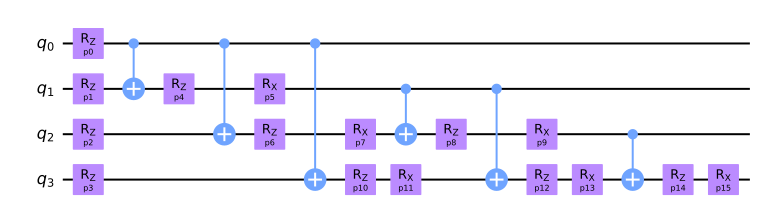

In [5]:
layer = QuantumCircuit(4, name = "layer")
vqc_params = []
num_params = 16 #number of parameters per layer

for i in range(4):
    param = Parameter('p{}'.format(i))
    vqc_params.append(param)
    layer.rz(param, i)
p=4
for i in range(1,4):
    for j in range(i):
        layer.cx(j,i)
        param = Parameter('p{}'.format(p))
        vqc_params.append(param)
        layer.rz(param, i)
        p+=1
        param = Parameter('p{}'.format(p))
        vqc_params.append(param)
        layer.rx(param, i)
        p+=1
# display the circuit named "layer" made here:
layer.draw('mpl')

The above diagram shows what each layer looks like. Finally the VQC with 4 such layers is generated with Hadamard Gates applied in between as explained above.

Number of variational parameters assigned per layer = 16
Number of layers used = 4


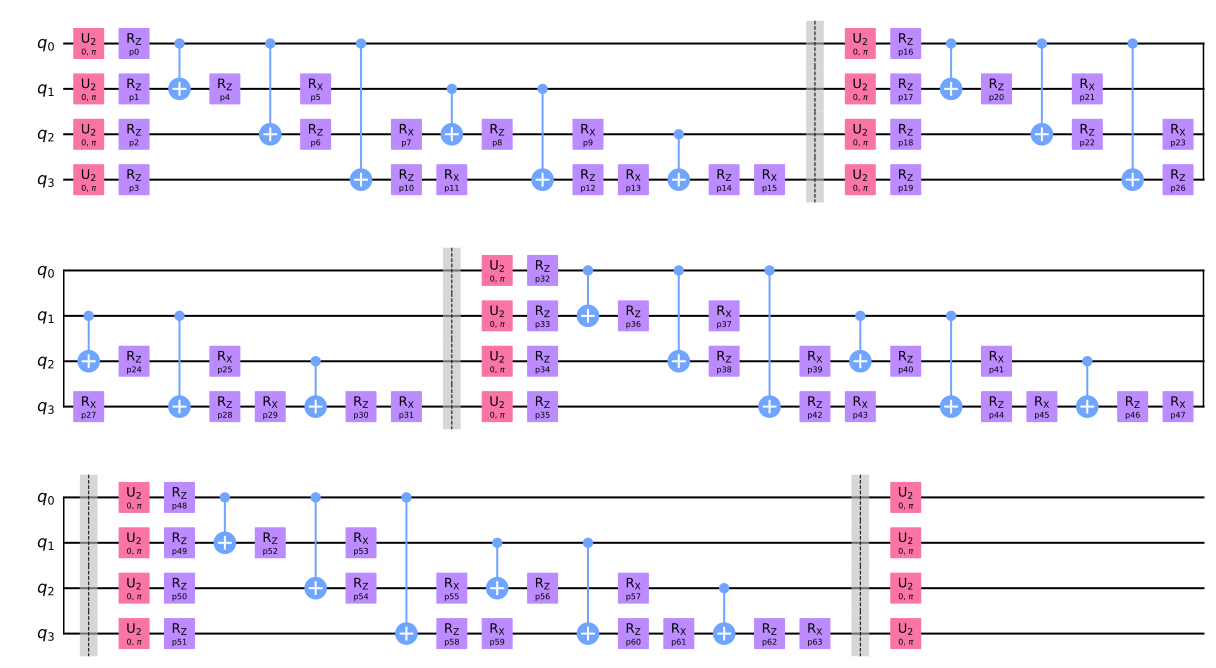

In [6]:
total_num_layers = 4 # max number of layers to be applied
vqc = QuantumCircuit(4)
num_layers = 0 # keep a count of the number of layers being applied
vqc.h(range(4))
#Assign new parameters
for i in range(total_num_layers): 
    params = {} 
    for t in range(num_params):
        param = Parameter('p{}'.format(t + num_layers*num_params))
        params[vqc_params[t]] = param
    _layer = layer.assign_parameters(params, inplace = False)
    _layer.name = 'layer{}'.format(i)
    vqc.append(_layer, range(4))
    vqc.barrier()
    vqc.h(range(4))
    num_layers += 1
# to show the number of params, layers and the variational quantum circuit to be used for the task:
print(f"Number of variational parameters assigned per layer = {num_params}",end='\n')
print(f"Number of layers used = {num_layers}",end='\n')
display(vqc.decompose().draw('mpl'))

In [7]:
#---------------------------------------------------------------------------------------------------------------------
iiii = 0 # purely for debugging purpose just to see if the circuit is being made properly and params are being updated
dbg = False
#---------------------------------------------------------------------------------------------------------------------

## Cost Function for the VQC parameter optimization:
The cost function is what the optimizer tries to minimize
over several iterations by evaluating it. Hence, the cost
function should be designed such in a manner so as to
fulfill the objectives. The objective here is to maximize
the probability of obtaining certain pre-defined state
for a certain randomly generated but fixed input state.

The Statevector Simulator can be effectively used to
execute the circuit designed above and stores the probabilities
of all the corresponding states in a dictionary. 

Now, to fulfill the objective, an incentive must be introduced
for the optimizer such that it tends to choose the desired
state every time.

This can be achieved by extracting all the probabilities 
and introducing a large penalty term (positive coefficient)
for all the undesired states and a small reward term 
(negative coefficient) for the desired state.

Smaller reward and higher penalty ensures that the optimizer,
in order to minimize the function, will pick the desired
state much more often, thereby satisfying our objective.

In [8]:
def cost_fnc(params):
    #declaring previously defined variables as global to avoid complexity in Optimizer calling the cost function
    global vqc
    global states
    global simltr
    global iiii
    cost_array = []
    for i, (in_, out_) in enumerate(mapping.items()):
        qcirc = states[i].compose( vqc.assign_parameters(params, inplace=False) ) 
        if iiii < 2 and dbg is True:
            display(qcirc.draw('mpl'))
            iiii+=1
        #Simulate and get probability
        res = simltr.execute(qcirc)
        statevec = Statevector(res.get_statevector())
        res_probs = statevec.probabilities_dict()
        winner = 0
        loser = 0
        for key in res_probs.keys():
            if(key==out_):
                winner += 0.1*res_probs.get(key, 0)
            else:
                loser += 10*res_probs.get(key,0)
            #Append result
        cost = loser-winner
        cost_array.append(cost)

    #Total cost=sum(negative_probabilities)
    return sum(cost_array)

In [9]:
final_params, final_cost, nfev = opt.optimize(num_params * num_layers, cost_fnc, initial_point = np.random.rand(num_params * num_layers))
print(f"Final optimised parameters : {final_params}",end='\n')
print(f"Final optimised cost : {final_cost}",end='\n')
print(f"Cost Fucntion was called : {nfev} times")

Final optimised parameters : [-8.791632e-05, -2.4487948e-05, 1.41365618, 1.74680791, 3.89792912e-05, 1.08655036, -0.000592609145, 0.252572798, 1.57087412, -4.84250417e-05, -2.96190569e-05, 0.0556224938, -1.06564915e-05, -0.423831738, -2.49706821e-05, 1.13457212e-07, -0.159661706, 1.57097153, 0.785417964, 1.92714236e-05, 1.57128867, 1.57072898, 1.86889889, 1.57079088, 1.570752, 0.912413111, 0.103584826, -0.172153863, 1.28715623, 0.658404157, -1.76404013e-05, 0.41820095, 0.785422505, -0.933363087, 1.60952112e-06, 1.5708349, 1.57082391, 1.3169154e-05, 0.120370753, -4.46873375e-05, 0.386504789, 1.57092081, 0.713486375, 3.34171132e-06, 1.57076468, -0.269681331, 3.86119922e-05, 0.857430197, -0.000212029822, 1.57075586, 0.000146075127, 2.50428096, 0.785374481, 2.74859874, 4.47675046e-05, 1.16679682, 3.14172148, -4.0832887e-05, -0.60705968, -3.06237165e-05, 0.648949283, 0.522054408, 0.524546186, 1.28861833]
Final optimised cost : -0.39999874450762185
Cost Fucntion was called : 3388 times


## Now the results of the training are exhibited.

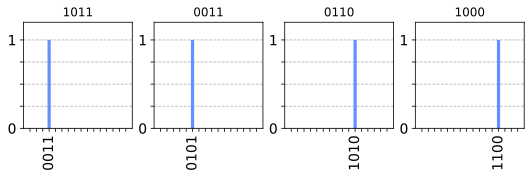

In [10]:
fig = plt.figure(figsize=(9, 9))
for i in range(4):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(in_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

# What happens if input states different from the ones the VQC was trained for are provided?

In [11]:
#generating the other possible input states
rem_states = [f'{i:4b}'.replace(' ','0') for i in range(16)]
for i,elem in enumerate(in_states):
    rem_states.remove(elem)
for item in rem_states:
    state = QuantumCircuit(4)
    for i in range(4):
        #adjusting for the endian-ness of qiskit
        if item[i] == "1": 
            state.x(3-i)
    states.append(state)

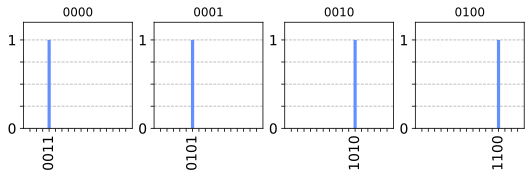

In [12]:
#to check the outputs for the remaining states that can be used as input to the VQC
fig = plt.figure(figsize=(9, 9))
for i in range(4):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(rem_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

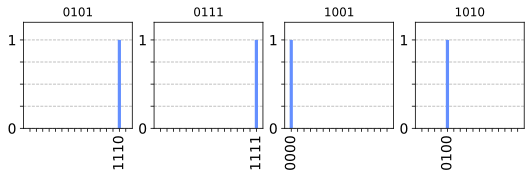

In [13]:
fig = plt.figure(figsize=(9, 9))
for i in range(4,8):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(rem_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

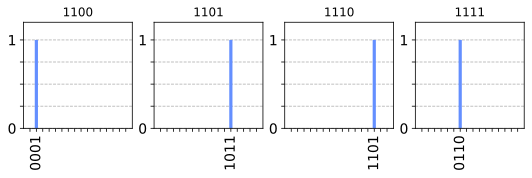

In [14]:
fig = plt.figure(figsize=(9, 9))
for i in range(8,12):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(rem_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

## Further Discussions: <br>
### 1. Results for other set of initial states:
i. Initial states = [`"0000"`, `"0100"`, `"1000"`,`"1100"`] <br>
<img src = "./0,4,8,12_4layer.png"/> <br> 
ii. Initial states = [`"0011"`, `"0110"`, `"1001"`, `"1010"`] <br>
<img src = "./3,6,9,10_4layer.png"/> <br> 
iii. Initial states = [`"1010"`, `"1011"`, `"1100"`, `"1101"`] <br>
<img src = "./10,11,12,13_4layer.png"/>

### 2. Reason behind choosing 4 layers.
Initially `total_num_layers` = 2 was used which resulted in a total of 32 variational parameters for the initial states :  

Number of variational parameters assigned per layer = 16
Number of layers used = 2


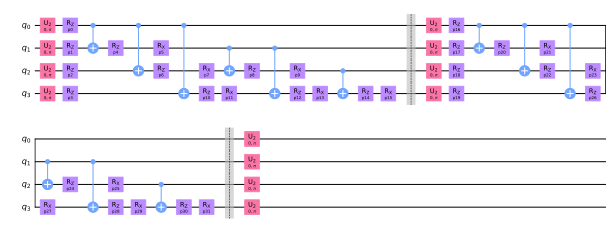

The mapping should look like:
1001  ->  0011
0011  ->  0101
0100  ->  1010
1110  ->  1100
Final optimised parameters : [2.8819684e-05, 1.5708638, -4.45084727e-05, 0.12438115, 1.57083392, -3.35542311e-05, 1.57078491, 0.929011206, 4.5843867e-05, -1.57080114, -1.57083318, 0.641803858, 1.57080108, 3.86848891e-05, 0.78431981, 9.29142181e-06, 1.58299301, -5.71002924e-06, -1.58299301, 1.57081155, -0.114008618, 6.80095024e-05, 0.11398599, 7.28498578e-05, 1.57084406, 0.568830728, 1.28377482e-05, -4.52961646e-05, 1.57084947, 1.57081047, 1.5707629, 5.82979847e-05]
Final optimised cost : -0.39999961400486866
Cost Function was called : 929 times


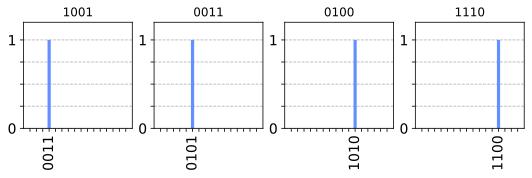

In [15]:
total_num_layers = 2 # max number of layers to be applied
vqc = QuantumCircuit(4)
num_layers = 0 # keep a count of the number of layers being applied
vqc.h(range(4))
#Assign new parameters
for i in range(total_num_layers): 
    params = {} 
    for t in range(num_params):
        param = Parameter('p{}'.format(t + num_layers*num_params))
        params[vqc_params[t]] = param
    _layer = layer.assign_parameters(params, inplace = False)
    _layer.name = 'layer{}'.format(i)
    vqc.append(_layer, range(4))
    vqc.barrier()
    vqc.h(range(4))
    num_layers += 1
# to show the number of params, layers and the variational quantum circuit to be used for the task:
print(f"Number of variational parameters assigned per layer = {num_params}",end='\n')
print(f"Number of layers used = {num_layers}",end='\n')
display(vqc.decompose().draw('mpl',scale=0.5))

out_states = target_states
in_states =  ["1001", "0011", "0100", "1110"]
states = []
for item in in_states:
    state = QuantumCircuit(4)
    for i in range(4):
        #Note: adjusted for the little-endian ness of qiskit
        if item[i] == "1": 
            state.x(3-i)
    states.append(state)
mapping = dict(zip(in_states,out_states))
print("The mapping should look like:")
for k,v in mapping.items():
    print(k,' -> ',v)

final_params, final_cost, nfev = opt.optimize(num_params * num_layers, cost_fnc, initial_point = np.random.rand(num_params * num_layers)) 
print(f"Final optimised parameters : {final_params}",end='\n')
print(f"Final optimised cost : {final_cost}",end='\n')
print(f"Cost Function was called : {nfev} times")

fig = plt.figure(figsize=(9, 9))
for i in range(4):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(in_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

This one was trained nicely. But not for the next one.

Number of variational parameters assigned per layer = 16
Number of layers used = 2


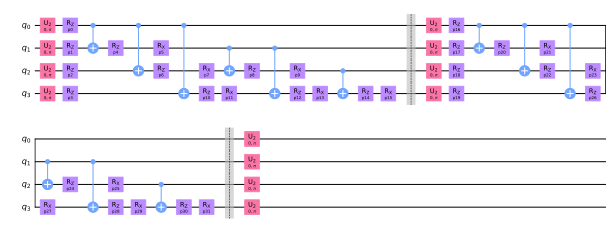

The mapping should look like:
0000  ->  0011
0001  ->  0101
0010  ->  1010
0100  ->  1100
Final optimised parameters : [-1.57083311, -6.34503785e-05, -3.1416714, 3.30407712, 3.39956904e-05, 2.97907566, 1.19380199, -0.00383822634, -2.35763921e-05, 1.49854108, 0.072306358, 0.00393512365, 3.96193085e-06, 0.909224891, -1.57074051, 0.661637682, 0.000272709292, 1.57086735, -9.41534093e-05, 5.67668741e-06, 1.01774731, 7.45352044e-05, 2.50078432, 1.57084739, -1.57074617, 0.0401066665, -5.07777969e-05, 1.9959951, -2.66879057e-05, -0.492036543, -0.0001756053, -0.51353966]
Final optimised cost : 9.700000574946321
Cost Function was called : 1064 times


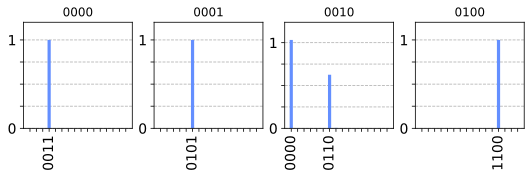

In [16]:
total_num_layers = 2 # max number of layers to be applied
vqc = QuantumCircuit(4)
num_layers = 0 # keep a count of the number of layers being applied
vqc.h(range(4))
#Assign new parameters
for i in range(total_num_layers): 
    params = {} 
    for t in range(num_params):
        param = Parameter('p{}'.format(t + num_layers*num_params))
        params[vqc_params[t]] = param
    _layer = layer.assign_parameters(params, inplace = False)
    _layer.name = 'layer{}'.format(i)
    vqc.append(_layer, range(4))
    vqc.barrier()
    vqc.h(range(4))
    num_layers += 1
# to show the number of params, layers and the variational quantum circuit to be used for the task:
print(f"Number of variational parameters assigned per layer = {num_params}",end='\n')
print(f"Number of layers used = {num_layers}",end='\n')
display(vqc.decompose().draw('mpl',scale=0.5))

out_states = target_states
in_states =  ["0000", "0001", "0010", "0100"]
states = []
for item in in_states:
    state = QuantumCircuit(4)
    for i in range(4):
        #Note: adjusted for the little-endian ness of qiskit
        if item[i] == "1": 
            state.x(3-i)
    states.append(state)
mapping = dict(zip(in_states,out_states))
print("The mapping should look like:")
for k,v in mapping.items():
    print(k,' -> ',v)

final_params, final_cost, nfev = opt.optimize(num_params * num_layers, cost_fnc, initial_point = np.random.rand(num_params * num_layers))
print(f"Final optimised parameters : {final_params}",end='\n')
print(f"Final optimised cost : {final_cost}",end='\n')
print(f"Cost Function was called : {nfev} times")

fig = plt.figure(figsize=(9, 9))
for i in range(4):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(in_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

This shows that the 2 layer version succeeds for 3 mappings but fails for one. This is why we switched to 3 layers next.

Number of variational parameters assigned per layer = 16
Number of layers used = 3


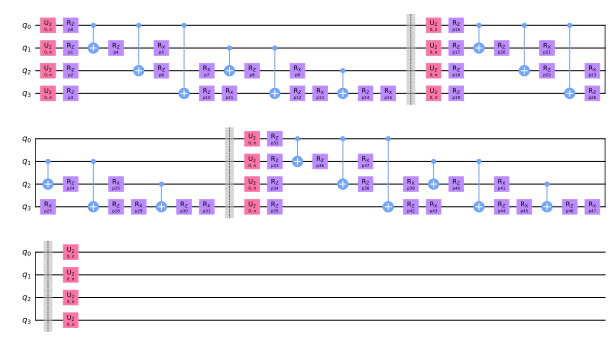

The mapping should look like
0000  ->  0011
0001  ->  0101
0010  ->  1010
0100  ->  1100
Final optimised parameters : [0.0649405099, -3.04415089e-06, 8.29256884e-05, 0.683857997, 1.23111382e-05, 0.588604214, 0.00039366991, 1.3685667, -0.00197336003, 0.717332061, 0.853445117, 1.37739984, -0.00489837141, 0.741609359, -3.37749722e-05, -0.0756027804, 0.000228833272, -0.070261739, -0.000226308604, -0.0015975862, 0.000382357913, 0.928910944, 0.351536165, -3.0113603e-05, 1.1228706e-05, -0.321694523, -1.69920985e-05, -5.30355127e-05, 1.18571236e-06, -0.0298312926, 1.52273532, -0.0439996356, 1.61466478e-05, -0.196861077, 1.24628211e-05, 6.76110874e-05, 0.730718074, 1.57078327, 1.57080816, 1.57082669, 0.816589943, -1.48069123e-05, 0.850964773, 0.790267647, 1.5707708, 0.557508629, -3.71817659e-05, 0.99004244]
Final optimised cost : 9.700000541670278
Cost Function was called : 2151 times


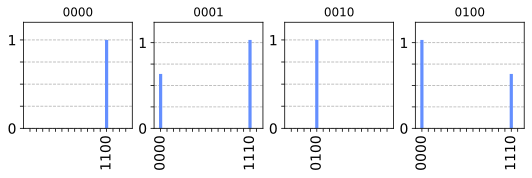

In [17]:
total_num_layers = 3 # max number of layers to be applied
vqc = QuantumCircuit(4)
num_layers = 0 # keep a count of the number of layers being applied
vqc.h(range(4))
#Assign new parameters
for i in range(total_num_layers): 
    params = {} 
    for t in range(num_params):
        param = Parameter('p{}'.format(t + num_layers*num_params))
        params[vqc_params[t]] = param
    _layer = layer.assign_parameters(params, inplace = False)
    _layer.name = 'layer{}'.format(i)
    vqc.append(_layer, range(4))
    vqc.barrier()
    vqc.h(range(4))
    num_layers += 1
# to show the number of params, layers and the variational quantum circuit to be used for the task:
print(f"Number of variational parameters assigned per layer = {num_params}",end='\n')
print(f"Number of layers used = {num_layers}",end='\n')
display(vqc.decompose().draw('mpl',scale=0.5))

out_states = target_states
in_states =  ["0000", "0001", "0010", "0100"]
states = []
for item in in_states:
    state = QuantumCircuit(4)
    for i in range(4):
        #Note: adjusted for the little-endian ness of qiskit
        if item[i] == "1": 
            state.x(3-i)
    states.append(state)
mapping = dict(zip(in_states,out_states))
print("The mapping should look like")
for k,v in mapping.items():
    print(k,' -> ',v)

final_params, final_cost, nfev = opt.optimize(num_params * num_layers, cost_fnc, initial_point = np.random.rand(num_params * num_layers))
print(f"Final optimised parameters : {final_params}",end='\n')
print(f"Final optimised cost : {final_cost}",end='\n')
print(f"Cost Function was called : {nfev} times")

fig = plt.figure(figsize=(9, 9))
for i in range(4):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(in_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

Thus the 3 layer version is also unable to map the states properly. Thus it can be concluded that 4 is the optimum number of layers that can be used which means a total of 64 parameters; increasing the number of layers increases the chance of successful mapping at the cost of increased runtime.